# Baseline Architecture
* test qdanalysis package functions
* rough out ML process

In [1]:
#auto reloading magic
%load_ext autoreload
%autoreload 2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import qdanalysis.strokedecomposition as sd
import qdanalysis.preprocessing as prep

from qdanalysis.models import adapt_resnet50

2024-01-24 14:20:21.058484: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


this is going to have to be done on a per file basis via path

In [2]:
#test data
eng_test = cv.imread(r'CERUG_EN_Test.png')
print(len(eng_test.shape))

#eng_test_bin = prep.preprocess(eng_test)

3


/tmp/ipykernel_26637/5660924.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


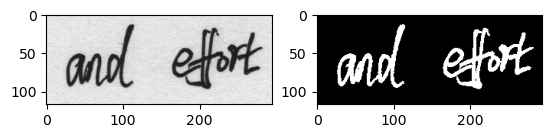

In [3]:
fig = plt.figure()
eng_ax = plt.subplot(1, 2, 1)
eng_ax.imshow(eng_test, cmap='gray')
eng_bin_Ax = plt.subplot(1, 2, 2)
eng_bin_Ax.imshow(prep.preprocess(eng_test), cmap='gray')
fig.show()

In [4]:
test = sd.simple_stroke_segment(eng_test)

/tmp/ipykernel_26637/2336598896.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  stroke_fig.show()


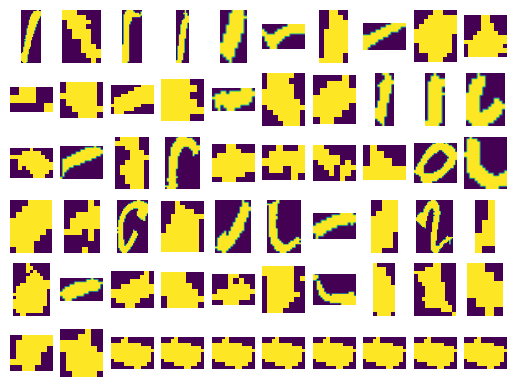

In [5]:
stroke_fig, stroke_axes = plt.subplots(6, 10)
count = 0
for row in stroke_axes:
    for ax in row:
        ax.axis('off')
        ax.imshow(test[count])
        count = min(count+1, len(test)-1)

stroke_fig.show()

In [6]:
test[0].astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [7]:
model = adapt_resnet50((64, 64, 3))
model.compile()

2024-01-24 14:20:25.302325: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-24 14:20:25.303153: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-01-24 14:20:25.337169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2024-01-24 14:20:25.337238: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-01-24 14:20:25.338473: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-01-24 14:20:25.338600: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              2049000   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10010     
Total params: 25,646,722
Trainable params: 2,059,010
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
height, width = test[0].shape
height, width

h = w = 64
h_d = h - height
w_d = h - width

top, bottom = h_d // 2, h_d - (h_d // 2)
top, bottom

left, right = w_d // 2, w_d - (w_d // 2)
left, right

test_padded = cv.copyMakeBorder(test[0].astype(float), top, bottom, left, right, cv.BORDER_CONSTANT, value = 0)
test_padded = cv.cvtColor(test_padded.astype(np.float32), cv.COLOR_GRAY2RGB)

In [10]:
test_padded.shape

(64, 64, 3)

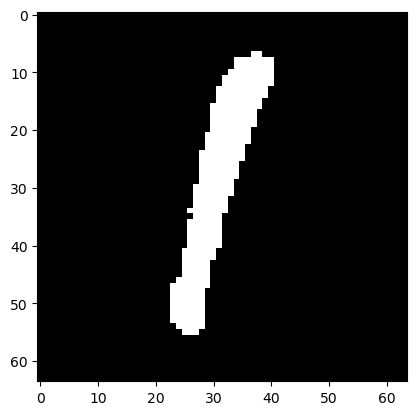

In [11]:
plt.imshow(test_padded)

In [12]:
fake_batch = test_padded.reshape(-1, 64, 64, 3)
model.predict(fake_batch)

2024-01-24 14:20:27.346284: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-01-24 14:20:27.363183: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2024-01-24 14:20:27.860644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-01-24 14:20:28.027145: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


array([[0.04737073, 0.19408712, 0.06419928, 0.24341981, 0.11568296,
        0.09145548, 0.03003194, 0.07856439, 0.06175359, 0.07343464]],
      dtype=float32)